# Machine Learning in Python - Project 2

Due Friday, Apr 11th by 4 pm.

*Include contributors names in notebook metadata or here*

## Setup

*Install any packages here, define any functions if neeed, and load data*

In [40]:
# Add any additional libraries or submodules below

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.model_selection import train_test_split

# Class balance
import seaborn as sns
import matplotlib.pyplot as plt

In [41]:
# Load data in easyshare.csv
d = pd.read_csv("freddiemac.csv", dtype={'id_loan_rr': str, 'rr_ind':str})
d.head()

,fico,dt_first_pi,flag_fthb,dt_matr,cd_msa,mi_pct,cnt_units,occpy_sts,cltv,dti,...,seller_name,servicer_name,flag_sc,id_loan_rr,program_ind,rr_ind,property_val,io_ind,mi_cancel_ind,loan_status
0,809,201705,N,204704,NaN,0,1,P,75,38,...,Other sellers,SPECIALIZED LOAN SERVICING LLC,NaN,NaN,9,NaN,2,N,7,prepaid
1,702,201703,N,203202,NaN,0,1,P,80,36,...,Other sellers,Other servicers,NaN,NaN,9,NaN,2,N,7,active
2,792,201703,N,204702,NaN,0,1,S,60,36,...,Other sellers,Other servicers,NaN,NaN,9,NaN,2,N,7,prepaid
3,776,201703,N,204702,NaN,0,1,S,80,18,...,Other sellers,Other servicers,NaN,NaN,9,NaN,2,N,7,prepaid
4,790,201703,N,204702,41620.0,0,1,I,75,42,...,Other sellers,"PNC BANK, NA",NaN,NaN,9,NaN,2,N,7,active


# Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a professional body (e.g. Freddie Mac).*

*Briefly outline the approaches being used and the conclusions that you are able to draw.*

# Exploratory Data Analysis and Feature Engineering


## 2.1. Label Distribution and Filtering

We focus on binary classification by filtering out loans that are still active and retaining only 'Prepaid' and 'Default' cases. It's important to assess the class balance to understand the level of imbalance in the dataset.

After filtering: (126705, 33)


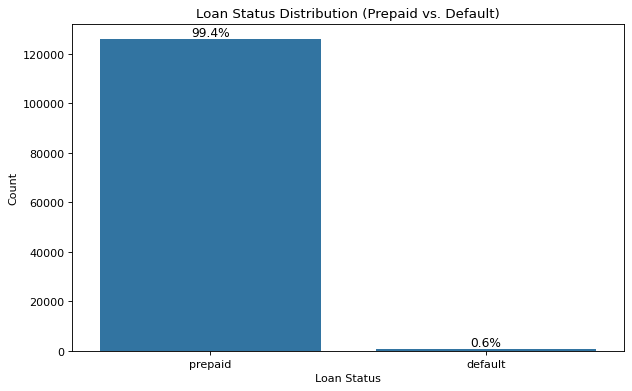

In [42]:
# 筛选数据
d_filtered = d[d['loan_status'].isin(['prepaid', 'default'])].copy()
print("After filtering:", d_filtered.shape)

# 绘图
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
ax = sns.countplot(data=d_filtered, x='loan_status', order=['prepaid', 'default'])
plt.title("Loan Status Distribution (Prepaid vs. Default)")
plt.xlabel("Loan Status")
plt.ylabel("Count")

# 柱上标注百分比
total = len(d_filtered)
for p in ax.patches:
    height = p.get_height()
    label = f'{100 * height / total:.1f}%'
    ax.annotate(label, (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

From the bar chart above, we observe that approximately 99.4% of the loans in our dataset were prepaid, while only 0.6% resulted in default. This indicates a highly imbalanced dataset, which may require special handling such as class weighting or resampling during model training.

## 2. Missing Values and Data Cleaning

We first check for missing values across the dataset. Special placeholder values such as 999, 9999, or string '9' are treated as missing. We drop columns with excessive missingness (>50%) and apply median or category-based imputation to others.

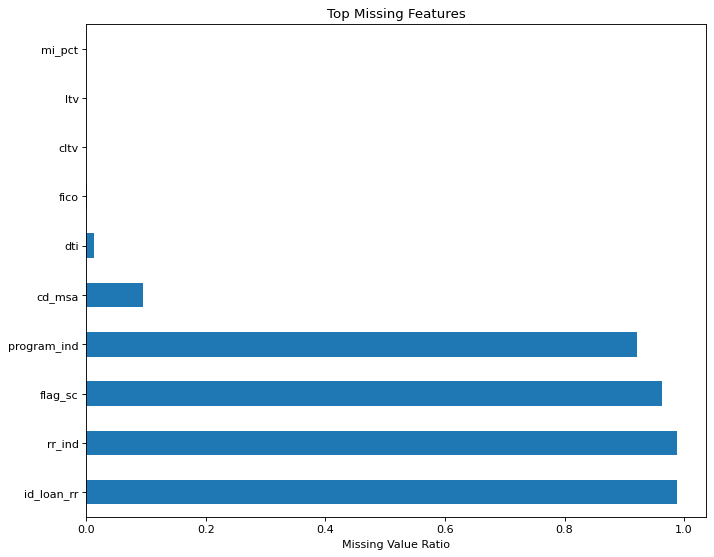

In [45]:
import numpy as np

# Replace common missing value markers with NaN
d.replace([999, 9999, '999', '9999', '9'], np.nan, inplace=True)

# Visualize missingness
missing = d.isna().mean().sort_values(ascending=False)
missing = missing[missing > 0]

missing.head(20).plot(kind='barh', figsize=(10, 8))
plt.xlabel('Missing Value Ratio')
plt.title('Top Missing Features')
plt.show()

### Missing Value Handling Strategy

After visualizing missingness, we determined that some features have excessive missing values (e.g. `mi_pct`, `cltv`, `dti`). Features with more than 50% missing values will be excluded from modeling. For remaining numerical features with moderate missingness, we use median imputation. Categorical features will be filled using a new 'missing' category when applicable.

In [46]:
# Identify features with high missing rate
high_missing = missing[missing > 0.5].index.tolist()
print("Dropped features due to high missingness:", high_missing)

# Drop features with excessive missing values
d.drop(columns=high_missing, inplace=True)

# Fill numerical columns with median
num_cols = d.select_dtypes(include=['float64', 'int64']).columns
d[num_cols] = d[num_cols].fillna(d[num_cols].median())

# Fill categorical columns with "missing"
cat_cols = d.select_dtypes(include='object').columns
d[cat_cols] = d[cat_cols].fillna("missing")

Dropped features due to high missingness: ['id_loan_rr', 'rr_ind', 'flag_sc', 'program_ind']


We conducted a comprehensive assessment of missing values in the dataset. The bar chart above shows the top features ranked by missing value ratio. Four features—`id_loan_rr`, `rr_ind`, `flag_sc`, and `program_ind`—had missing values in more than 90% of the records. These features were deemed unlikely to contribute meaningful information and were therefore dropped from the dataset.

Other features with lower but notable missingness include `cd_msa`, `dti`, and `mi_pct`. For these, we applied appropriate imputation strategies: numerical features were filled using the median, and categorical features were filled with the string `'missing'` to preserve the information about data absence.

By removing highly sparse features and imputing the remaining ones, we aim to minimize data loss while maintaining modeling performance. The cleaned dataset is now free of high-missingness columns and ready for further exploratory analysis.

## 3. Numerical Features and Default Risk

We examine the distribution of selected numerical features, such as credit score (FICO), loan-to-value ratio (LTV), and debt-to-income ratio (DTI). These distributions are compared across default and prepaid classes.

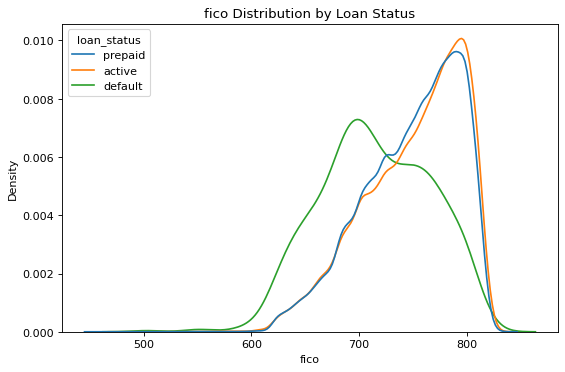

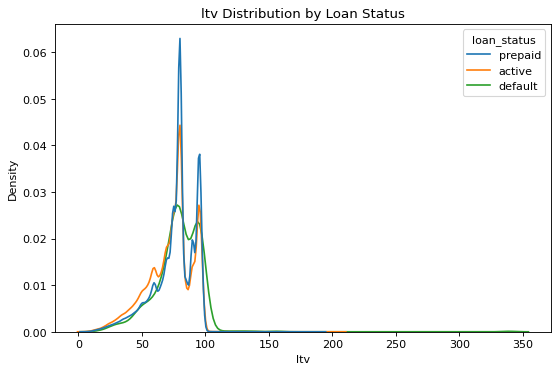

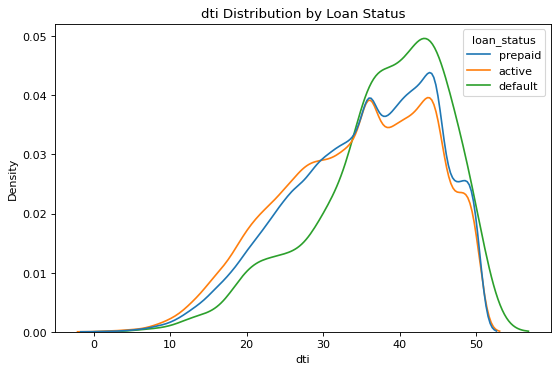

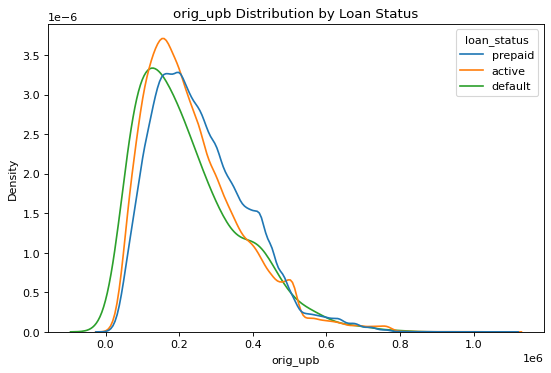

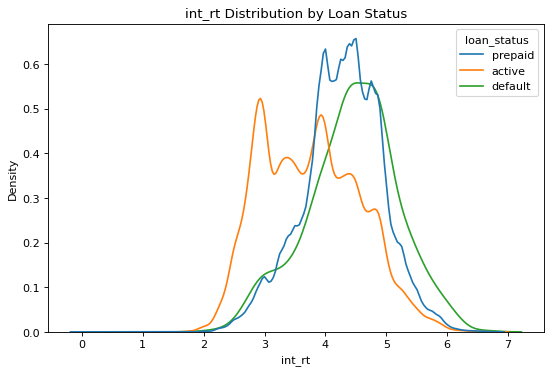

In [47]:
num_vars = ['fico', 'ltv', 'dti', 'orig_upb', 'int_rt']

for col in num_vars:
    if col in d.columns:
        sns.kdeplot(data=d, x=col, hue='loan_status', common_norm=False)
        plt.title(f'{col} Distribution by Loan Status')
        plt.xlabel(col)
        plt.ylabel('Density')
        plt.show()

We compare the distributions of key numerical features across the three loan statuses: `prepaid`, `default`, and `active`. Several notable patterns emerge:

- **FICO Score**: Defaulted loans tend to have significantly lower FICO scores compared to prepaid and active loans. The default curve is centered closer to 700, while prepaid loans are concentrated near 780+.
  
- **LTV (Loan-to-Value)**: Higher LTV ratios are more common among defaulted loans, suggesting that borrowers with less equity in their homes are more likely to default.

- **DTI (Debt-to-Income Ratio)**: Defaulted loans show a right-skewed DTI distribution, with more borrowers having DTI values closer to the upper limit (~50), indicating higher financial stress.

- **Origination UPB (Original Loan Amount)**: The loan amount distribution is broadly similar across classes, but defaulted loans show a slight shift toward higher values.

- **Interest Rate (int_rt)**: Prepaid loans tend to have lower interest rates than defaults. Interestingly, defaulted and active loans overlap more in this distribution, suggesting less predictive power.

These patterns support the intuition that borrowers with low creditworthiness (low FICO), high leverage (high LTV/DTI), and larger loans are more prone to default.

### Outlier Detection

We check for extreme values in numeric fields such as `dti`, `ltv`, and `fico`. Outliers may reduce model performance or mislead training. We remove or clip values that exceed plausible thresholds based on domain knowledge.

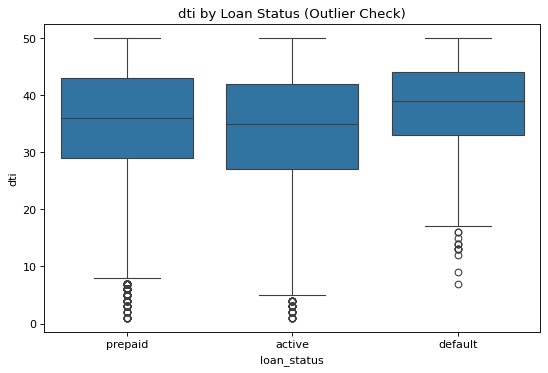

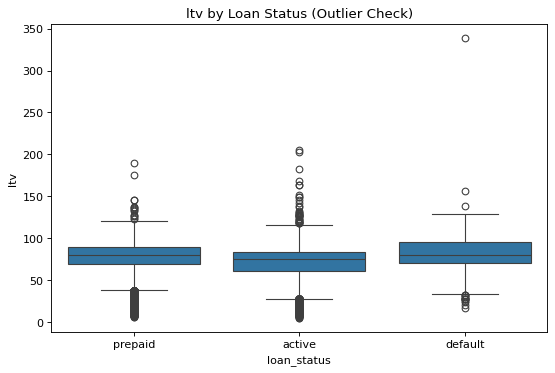

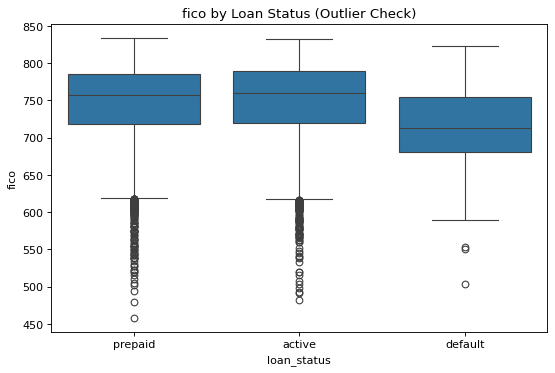

In [48]:
# Visualize outliers using boxplots
for col in ['dti', 'ltv', 'fico']:
    if col in d.columns:
        sns.boxplot(data=d, x='loan_status', y=col)
        plt.title(f'{col} by Loan Status (Outlier Check)')
        plt.show()

# Example: Remove outliers in DTI > 65 (based on documentation)
d = d[d['dti'] <= 65]

# Optional: Cap LTV at 150%
d['ltv'] = d['ltv'].clip(upper=150)

To assess potential outliers and value distributions, we generated boxplots for several key numerical features grouped by loan status:

- **FICO Score**: Defaulted loans show lower median FICO scores compared to prepaid and active loans. Moreover, there are numerous low-end outliers (below 600), which could indicate severely risky borrowers.

- **LTV (Loan-to-Value)**: While most values fall below 100%, several loans in each status class exceed this threshold, especially defaults. Some extreme outliers go above 300%, which is likely unrealistic and warrants capping or removal.

- **DTI (Debt-to-Income Ratio)**: The upper whisker for DTI consistently reaches 50, the presumed hard cap in the data. Many lower-end outliers (below 10) are also present. These extreme values may reduce model robustness and should be treated cautiously.

These visualizations highlight the importance of addressing extreme values through techniques such as clipping, log-transforming, or flagging, especially for variables like `fico`, `ltv`, and `dti`, which heavily influence default risk.

## 4. Categorical Features and Default Risk

We investigate how the default rate varies across different categories of key features, such as loan purpose, origination channel, and property type.

C:\Users\rjx10\AppData\Local\Temp\ipykernel_10584\684197119.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\rjx10\AppData\Local\Temp\ipykernel_10584\684197119.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\rjx10\AppData\Local\Temp\ipykernel_10584\684197119.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\rjx10\AppData\Local\Temp\ipykernel_10584\684197119.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=

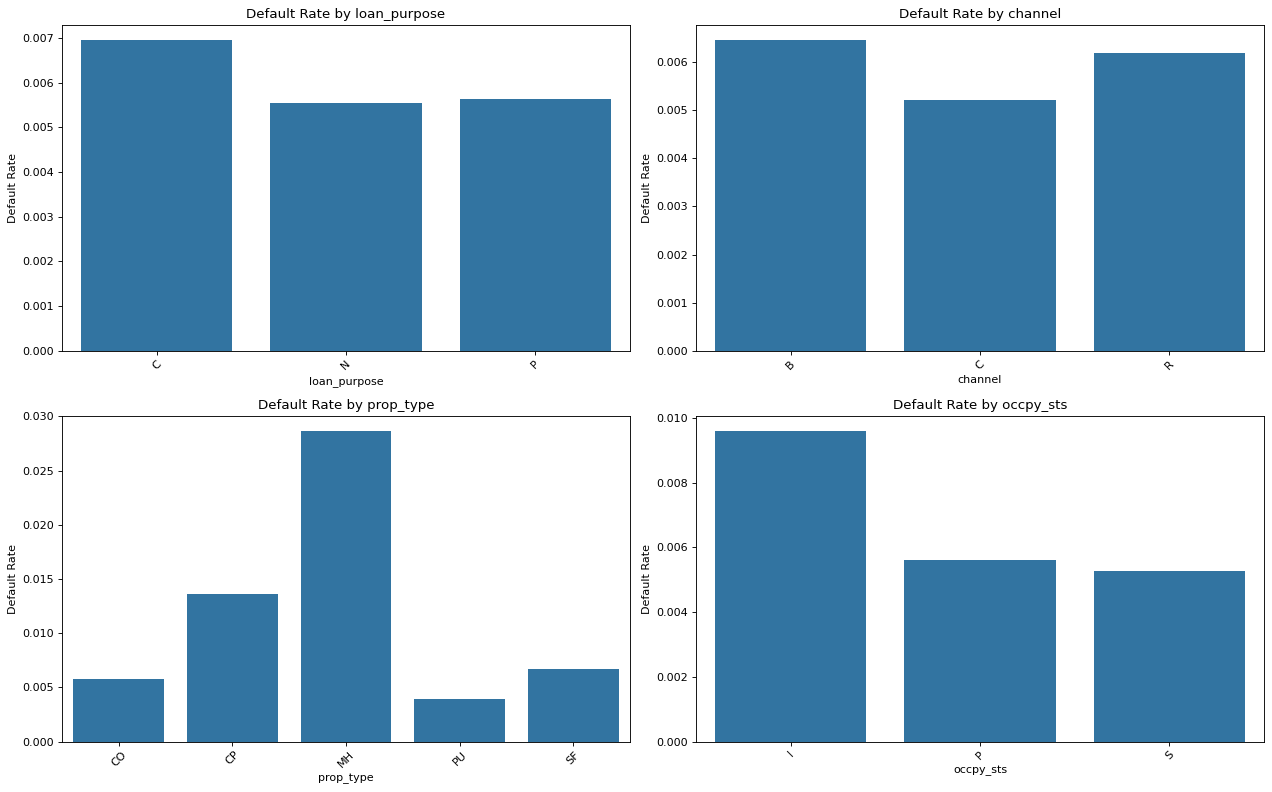

In [51]:
d = d[d['loan_status'].isin(['prepaid', 'default'])].copy()
d['loan_status_bin'] = d['loan_status'].map({'prepaid': 0, 'default': 1})

categorical_features = ['loan_purpose', 'channel', 'prop_type', 'occpy_sts']
plot_data = []

for feature in categorical_features:
    if feature in d.columns:
        temp = d[[feature, 'loan_status_bin']].dropna()
        if not temp.empty and temp[feature].nunique() > 1:
            summary = temp.groupby(feature)['loan_status_bin'].mean().reset_index()
            summary.columns = [feature, 'default_rate']
            plot_data.append((feature, summary))

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
axes = axes.flatten()

for ax, (feature, summary) in zip(axes, plot_data):
    sns.barplot(data=summary, x=feature, y='default_rate', ax=ax)
    ax.set_title(f'Default Rate by {feature}')
    ax.set_ylabel('Default Rate')
    ax.set_xlabel(feature)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

We analyzed how the default rate varies across selected categorical variables:

- **Loan Purpose**: Loans issued for refinancing (`C`) show slightly higher default rates than those for purchase (`P`) or other purposes (`N`). This may reflect increased leverage or riskier borrower profiles among refinancers.

- **Channel**: Loans originated through broker channels (`B`) exhibit higher default rates compared to retail (`R`) or correspondent (`C`) channels, suggesting that channel-level credit screening may differ in effectiveness.

- **Property Type**: Mobile homes (`MH`) stand out with a significantly higher default rate (~2.9%) compared to condos (`CO`), single-family residences (`SF`), or planned unit developments (`PU`). This aligns with industry trends where mobile home loans carry higher credit risk.

- **Occupancy Status**: Investment properties (`I`) show the highest default rate among all occupancy types, reinforcing the idea that borrowers are more likely to default on non-owner-occupied properties. Principal residences (`P`) and second homes (`S`) show similar and lower default risks.

These patterns reveal that categorical features carry useful signals for predicting default risk and should be retained during feature engineering and model training.

# Model Fitting and Tuning

*In this section you should detail and motivate your choice of model and describe the process used to refine, tune, and fit that model. You are encouraged to explore different models but you should NOT include a detailed narrative or code of all of these attempts. At most this section should briefly mention the methods explored and why they were rejected - most of your effort should go into describing the final model you are using and your process for tuning and validating it.*

*This section should include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.*

*Finally, you should also provide a comparison of your model with a baseline model of your choice on the test data but only briefly describe the baseline model considered.*

# Discussion & Conclusions

*In this section you should provide a general overview of your final model, its performance, and reliability. You should discuss what the implications of your model are in terms of the included features, estimated parameters and relationships, predictive performance, and anything else you think is relevant.*

*This should be written with a target audience of a banking official, who is understands the issues associated with mortgage defaults but may only have university level mathematics (not necessarily postgraduate statistics or machine learning). Your goal should be to highlight to this audience how your model can useful. You should also discuss potential limitations or directions of future improvement of your model.*

*Finally, you should include recommendations on factors that may increase the risk of default, which may be useful for the companies to improve their understanding of
mortgage defaults, and also to explain their decisions to clients and regulatory bodies. You should also use your model to inform the company of any active loans that are at risk of default.*

*Keep in mind that a negative result, i.e. a model that does not work well predictively, that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explinations / justifications.*

# Generative AI statement

*Include a statement on how generative AI was used in the project and report.*

# References

*Include references if any*

In [11]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf project2.ipynb

[NbConvertApp] Converting notebook project2.ipynb to pdf
[NbConvertApp] Support files will be in project2_files\
[NbConvertApp] Making directory .\project2_files
[NbConvertApp] Writing 53466 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | b had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 382884 bytes to project2.pdf
